In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Limpeza dos Dados

In [54]:
df = pd.read_csv('data.csv', encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [56]:
# Remover registros com valores inválidos Como, Quantity <= 0 ou UnitPrice <= 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [57]:
# Verificando se existem valores nulos
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [58]:
# Remover valores nulos
df = df.dropna()

In [59]:
df.drop(['Description'], axis=1, inplace=True)

In [60]:
# Análise descritiva dos dados
df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [61]:
# Convertendo a coluna 'InvoiceDate' para datetime:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [62]:
# Criar uma coluna de valor total por item
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

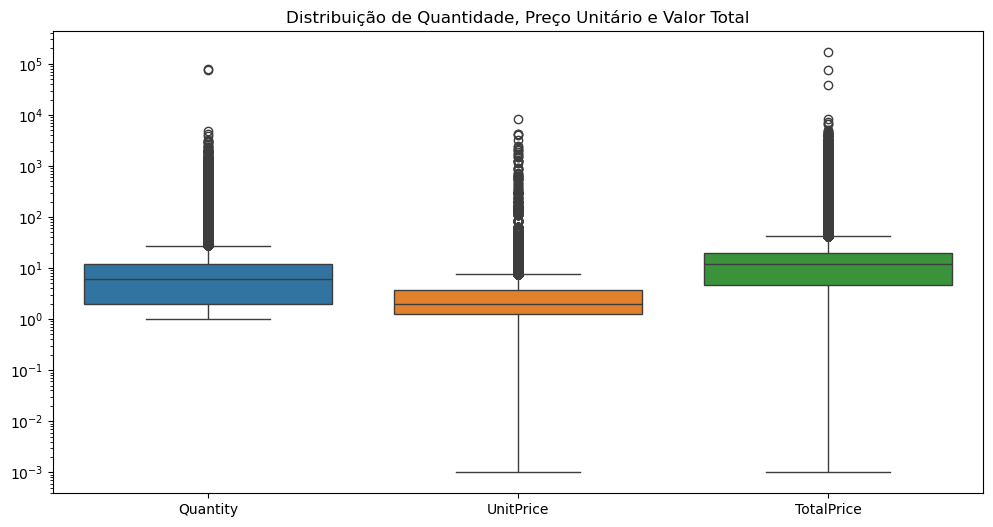

In [63]:
# Verificar outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Quantity', 'UnitPrice', 'TotalPrice']])
plt.yscale('log')  # Usar escala log para melhor visualização
plt.title('Distribuição de Quantidade, Preço Unitário e Valor Total')
plt.show()

In [64]:
#Remover outliers extremos (opcional, dependendo dos dados)
df = df[df['TotalPrice'] < df['TotalPrice'].quantile(0.999)]

## Análise Exploratória (EDA)

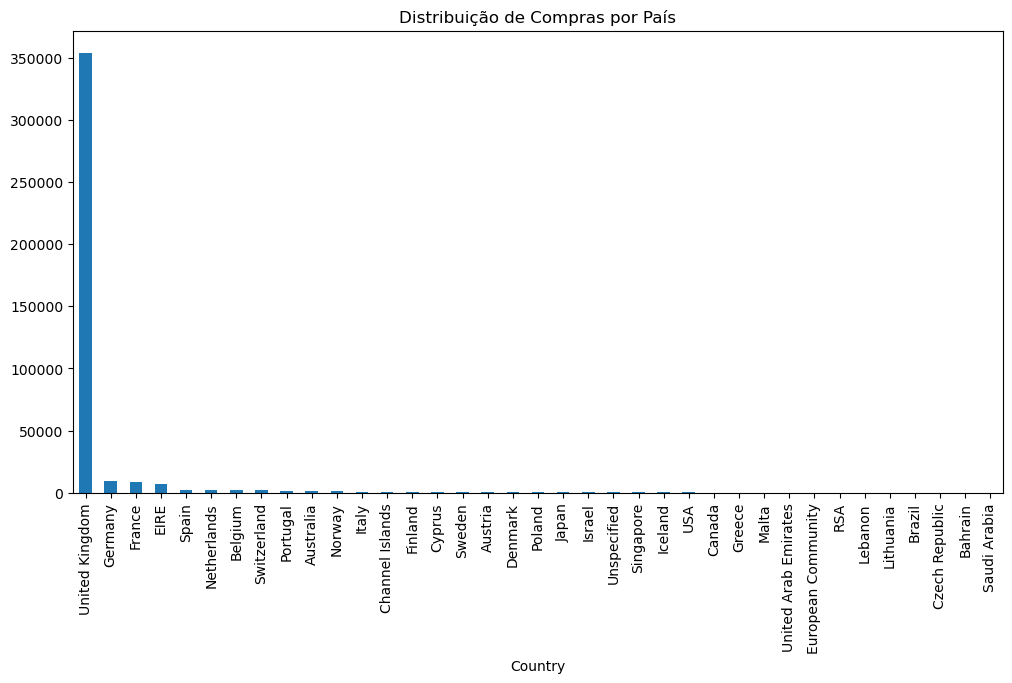

In [66]:
# Distribuição de compras por país
plt.figure(figsize=(12,6))
df['Country'].value_counts().plot(kind='bar')
plt.title('Distribuição de Compras por País')
plt.show()

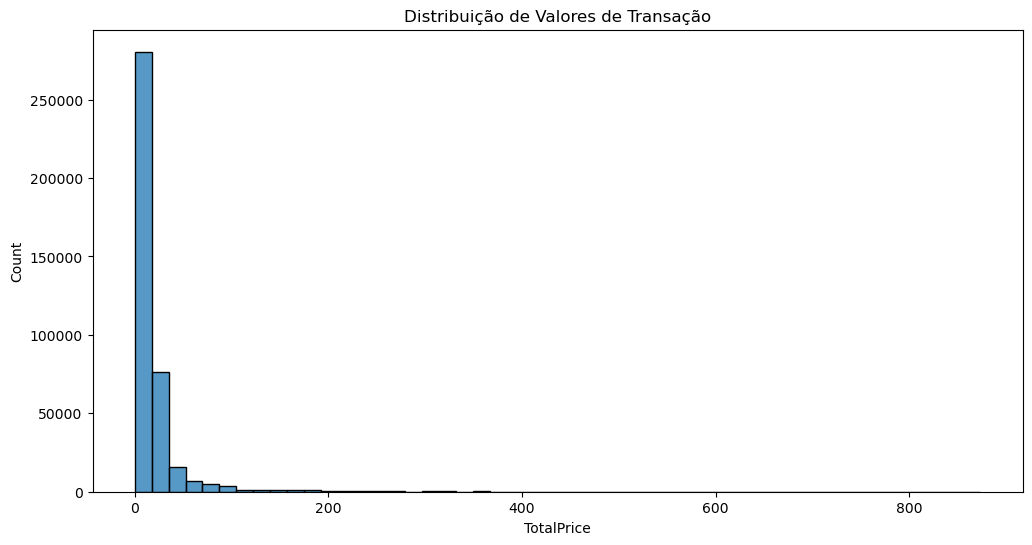

In [68]:
# Distribuição de valores
plt.figure(figsize=(12,6))
sns.histplot(df['TotalPrice'], bins=50)
plt.title('Distribuição de Valores de Transação')
plt.show()


C:\Users\Mauro Jorge Ernesto\AppData\Local\Temp\ipykernel_8696\921442250.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('InvoiceDate')['TotalPrice'].resample('M').sum().plot()


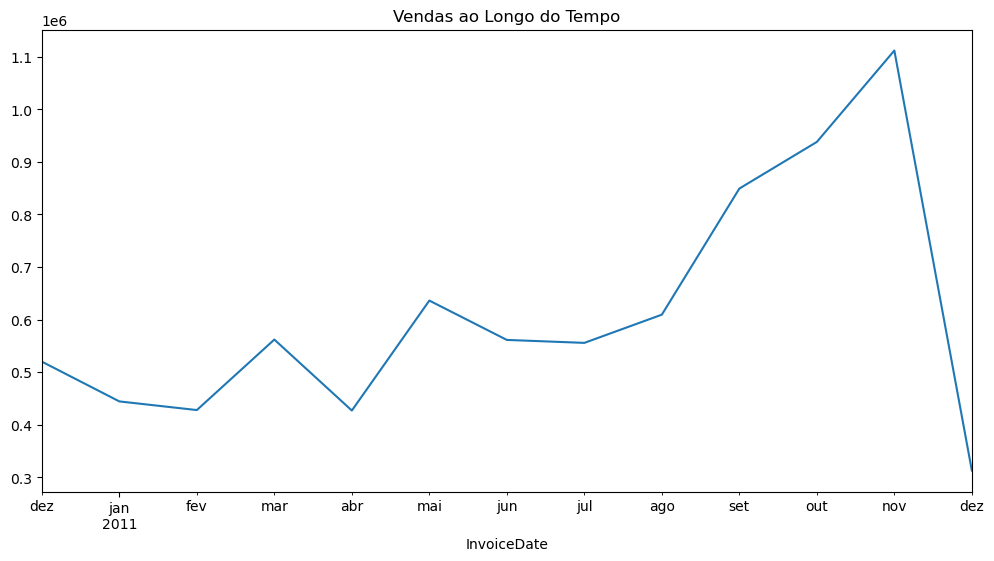

In [70]:
# Série temporal de compras
plt.figure(figsize=(12,6))
df.set_index('InvoiceDate')['TotalPrice'].resample('M').sum().plot()
plt.title('Vendas ao Longo do Tempo')
plt.show()

## Cálculo das Métricas RFM

In [71]:
# Definir data de referência (última data + 1 dia)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calcular métricas RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recência
    'InvoiceNo': 'nunique',  # Frequência
    'TotalPrice': 'sum'  # Valor Monetário
})

# Renomear colunas
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Remover outliers (opcional)
rfm = rfm[rfm['Monetary'] > 0]

## Transformação e Normalização dos Dados

In [72]:
# Aplicar log transform para normalizar distribuição
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis=1).round(3)

# Padronizar os dados
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary'])

## Determinar o Número Ótimo de Clusters

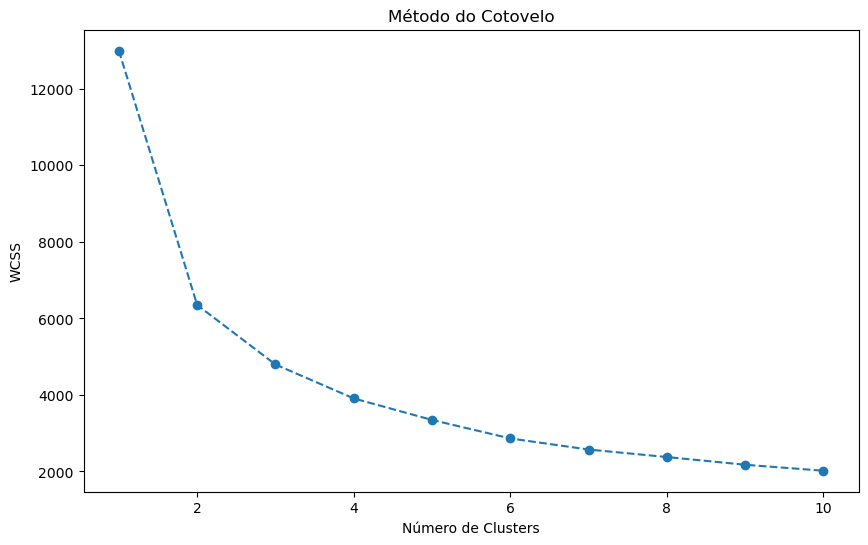

In [73]:
# Método do cotovelo para determinar k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método do Cotovelo')
plt.show()

## Aplicar Clusterização K-Means

In [84]:
# Definir número de clusters (baseado no método do cotovelo)
k = 4  # ajustar conforme necessário

# Aplicar K-means
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

# Adicionar clusters ao DataFrame RFM
rfm['Cluster'] = clusters

## Análise dos Clusters

In [85]:
# Estatísticas por cluster
cluster_stats = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_stats)

        Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          21.7       1.8    462.1   795
1          10.4      12.9   6679.3   758
2          70.9       4.1   1579.6  1275
3         189.8       1.3    339.6  1504


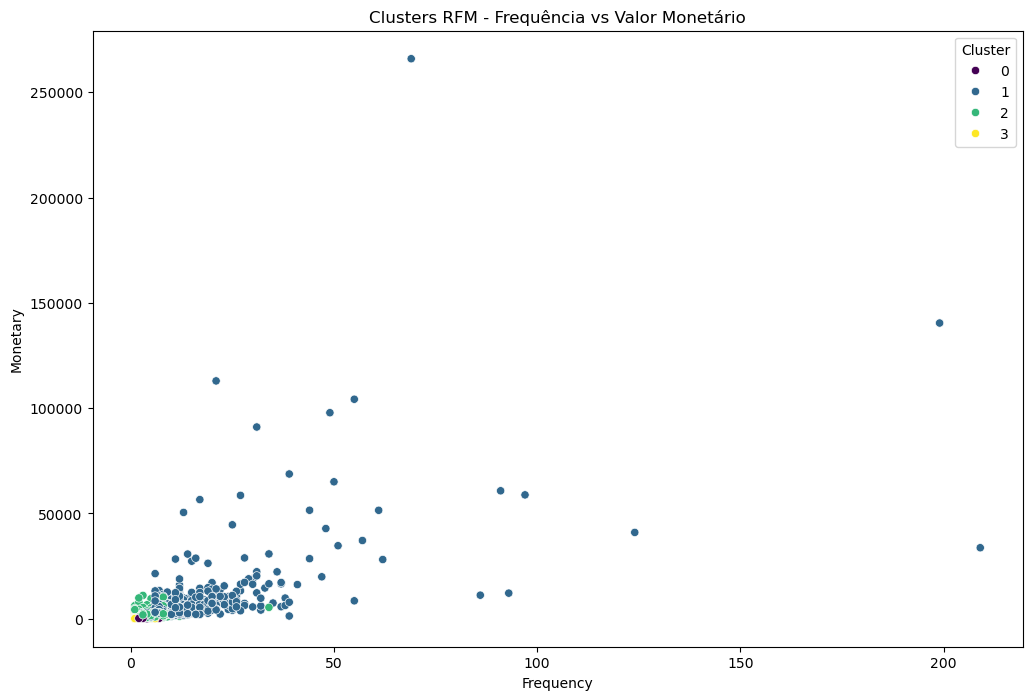

In [86]:
# Visualização dos clusters
plt.figure(figsize=(12,8))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Clusters RFM - Frequência vs Valor Monetário')
plt.show()

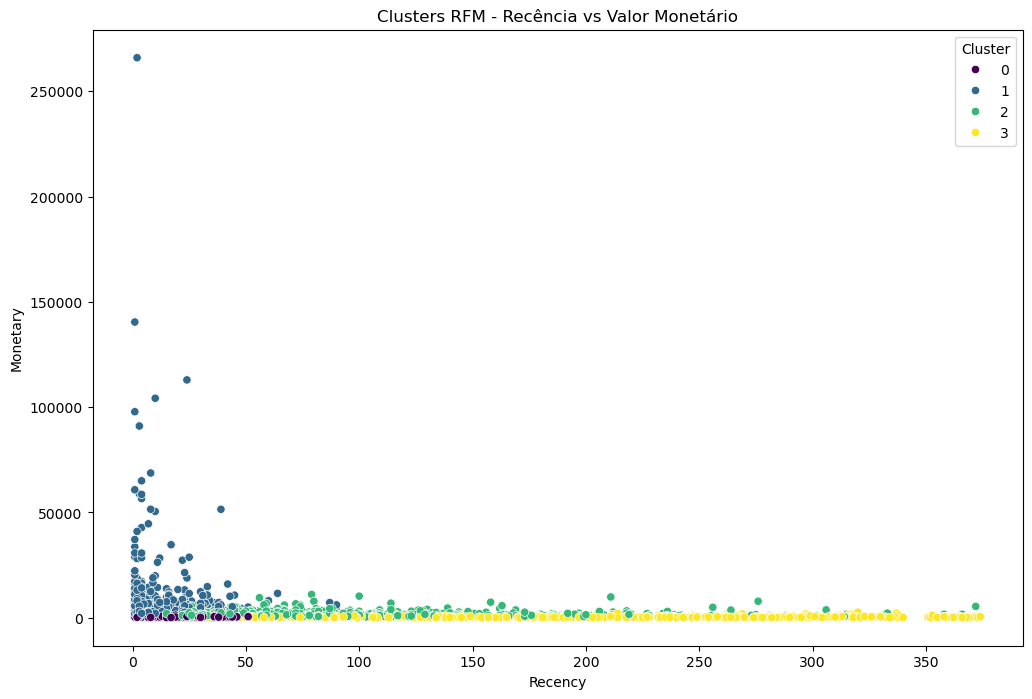

In [87]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Clusters RFM - Recência vs Valor Monetário')
plt.show()

## Interpretação dos Clusters

In [88]:
# Interpretar os clusters (ajustar conforme os resultados)
cluster_labels = {
    0: "Clientes Inativos",
    1: "Clientes Valiosos",
    2: "Clientes Novos",
    3: "Clientes em Risco"
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

# Análise final por segmento
segment_stats = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).round(1)

print(segment_stats)

                   Recency  Frequency  Monetary  Cluster
Segment                                                 
Clientes Inativos     21.7        1.8     462.1      795
Clientes Novos        70.9        4.1    1579.6     1275
Clientes Valiosos     10.4       12.9    6679.3      758
Clientes em Risco    189.8        1.3     339.6     1504


## gráficos para auxiliar na análise

C:\Users\Mauro Jorge Ernesto\AppData\Local\Temp\ipykernel_8696\1035070495.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Recency', data=segment_stats, palette='viridis')


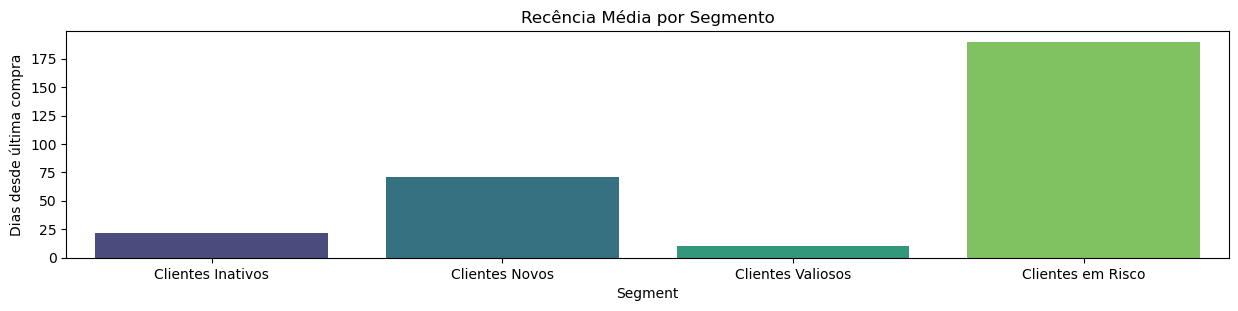

In [96]:
plt.figure(figsize=(15, 10))

# Gráfico de Recência
plt.subplot(3, 1, 1)
sns.barplot(x='Segment', y='Recency', data=segment_stats, palette='viridis')
plt.title('Recência Média por Segmento')
plt.ylabel('Dias desde última compra')
plt.show()

C:\Users\Mauro Jorge Ernesto\AppData\Local\Temp\ipykernel_8696\493314183.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Frequency', data=segment_stats, palette='viridis')


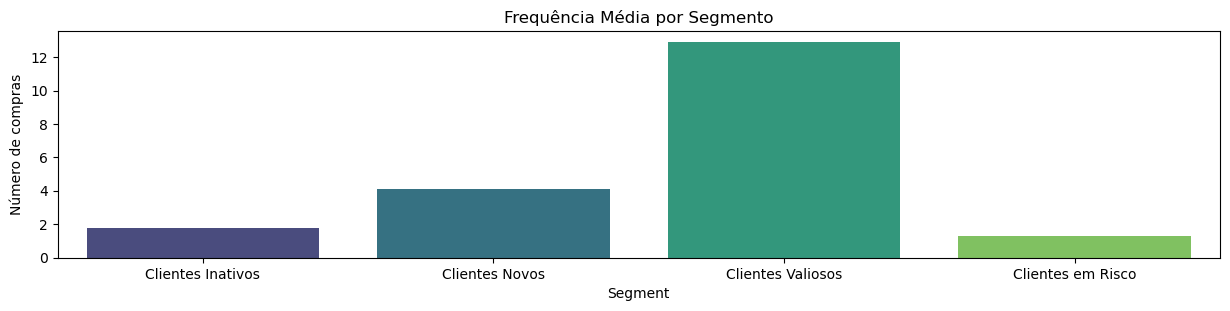

In [95]:
# Gráfico de Frequência
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 2)
sns.barplot(x='Segment', y='Frequency', data=segment_stats, palette='viridis')
plt.title('Frequência Média por Segmento')
plt.ylabel('Número de compras')
plt.show()

C:\Users\Mauro Jorge Ernesto\AppData\Local\Temp\ipykernel_8696\3772138923.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Monetary', data=segment_stats, palette='viridis')


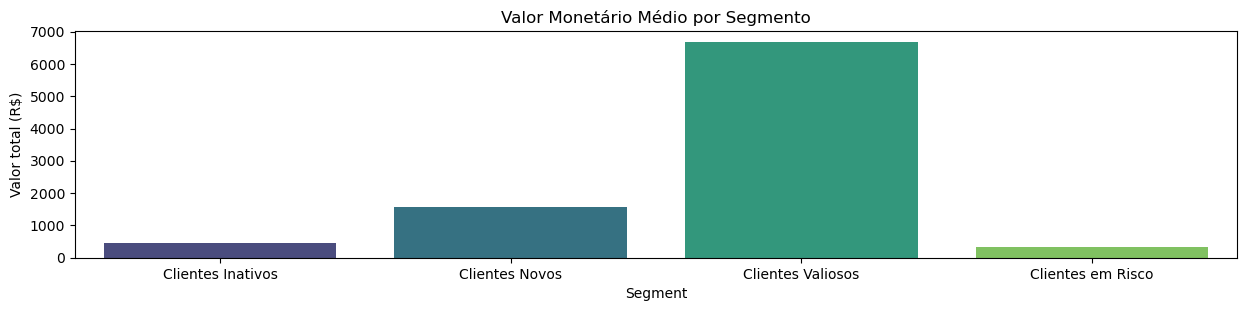

In [98]:
# Gráfico de Valor Monetário
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 3)
sns.barplot(x='Segment', y='Monetary', data=segment_stats, palette='viridis')
plt.title('Valor Monetário Médio por Segmento')
plt.ylabel('Valor total (R$)')
plt.show()

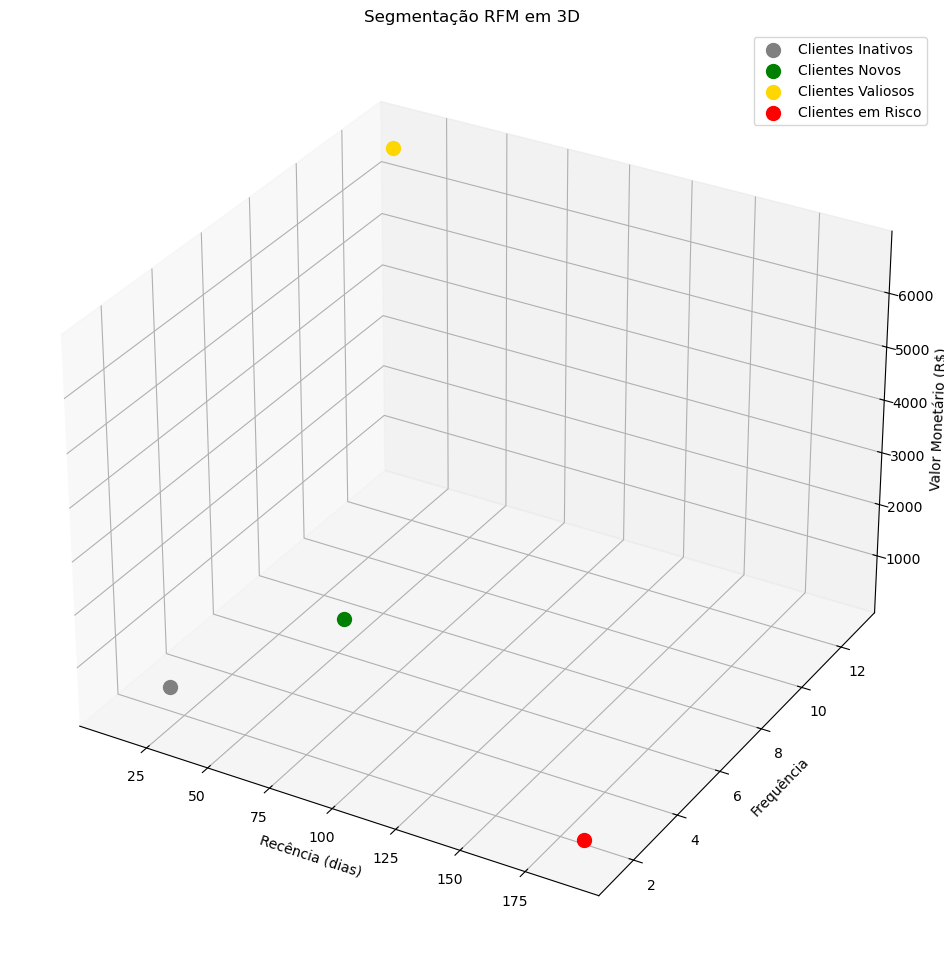

In [ ]:
# Resetar o índice para transformar 'Segment' em coluna novamente
segment_stats = segment_stats.reset_index()

# Agora o gráfico 3D:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

colors = {'Clientes Inativos': 'gray', 
          'Clientes Novos': 'green',
          'Clientes Valiosos': 'gold',
          'Clientes em Risco': 'red'}

for seg in segment_stats['Segment']:
    ax.scatter(segment_stats[segment_stats['Segment']==seg]['Recency'],
               segment_stats[segment_stats['Segment']==seg]['Frequency'],
               segment_stats[segment_stats['Segment']==seg]['Monetary'],
               s=100, c=colors[seg], label=seg)

ax.set_xlabel('Recência (dias)')
ax.set_ylabel('Frequência')
ax.set_zlabel('Valor Monetário (R$)')
ax.set_title('Segmentação RFM em 3D')
plt.legend()
plt.show()

## Interpretação dos resultados obtidos

## Clientes Valiosos (ouro):
    Baixa recência (10.4 dias)
    Alta frequência (12.9 compras)
    Alto valor monetário (R$6679.3)
    → Estratégia: Fidelização (programas VIP, benefícios exclusivos)

## Clientes Novos (verde):
    Recência moderada (70.9 dias)
    Frequência média (4.1 compras)
    Valor monetário relevante (R$1579.6)
    → Estratégia: Engajamento (ofertas personalizadas, onboarding)

## Clientes Inativos (cinza):
    Recência baixa (21.7 dias) mas com pouca frequência (1.8) e valor (R$462.1)
    → Estratégia: Reativação (cupons de desconto, lembretes)

## Clientes em Risco (vermelho):
    Alta recência (189.8 dias)
    Baixíssima frequência (1.3) e valor (R$339.6)
    → Estratégia: Recuperação (pesquisas de satisfação, ofertas agressivas)